# Big Data Management Project 1:
## Analyzing New York City Taxi Data

In [1]:
!pip install shapely

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, unix_timestamp, col, lag, avg, lead, count, sum as spark_sum
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
from pyspark.sql.window import Window

import json
import time

from shapely.geometry import shape, Point

In [3]:
spark = (SparkSession.builder
                    .appName('BDM_Project1')
                    .enableHiveSupport()
                    .getOrCreate()
        )

### NYC Borough Data

In [4]:
with open('input/nyc-boroughs.geojson') as f:
    geo_data = json.load(f)

# Broadcasting data to workers
broadcast_geo_data = spark.sparkContext.broadcast(geo_data)

# Creating a dictionary of borough codes and polygons within the borough
polygons = {}
b_names = {} # borough names by code

for feature in broadcast_geo_data.value['features']:

    code = feature['properties']['boroughCode']
    name = feature['properties']['borough']

    if code not in polygons:
        polygons[code] = []
        b_names[code] = name

    polygons[code].append(shape(feature['geometry']))

# Sorting borough polygons by area
for code in polygons:
    polygons[code] = sorted(
        polygons[code], key=lambda x: x.area, reverse=True
    )

In [5]:
# UDF: longitude, latitude -> borough
def get_borough(long, lat):
    point = Point(long, lat)

    for code, pols in polygons.items():
        for polygon in pols:
            if polygon.contains(point):
                return code

    return None

get_borough_udf = udf(get_borough, IntegerType())

### NYC Taxi Data

In [6]:
start_time = time.time() # To see the time it takes to execute data transformations

# Defining the schema for faster reading of data
schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("vendor_id", StringType(), True),
    StructField("rate_code", StringType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", StringType(), True),
    StructField("trip_time_in_secs", StringType(), True),
    StructField("trip_distance", StringType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True)
])

# Creating a single dataframe of all the trip_data files
taxi_df_og = (spark.read
             .option("sep", ",")
             .option("header", True)
             .schema(schema)
             .csv("input/trip_data/trip_data_*.csv")
             #.csv(["input/trip_data/trip_data_1.csv"])
          )

# Removing the trips with 0 passengers
# Transforming the data (further explained in the project report)
taxi_df = taxi_df_og.filter(
    (taxi_df_og.passenger_count != "0") &
    ~(
        (taxi_df_og.trip_distance == 0) &
        (taxi_df_og.pickup_longitude == taxi_df_og.dropoff_longitude) &
        (taxi_df_og.pickup_latitude == taxi_df_og.dropoff_latitude)
    )
).withColumns({
    "pickup_ts": unix_timestamp("pickup_datetime", "dd-MM-yy HH:mm"),
    "dropoff_ts": unix_timestamp("dropoff_datetime", "dd-MM-yy HH:mm")
}).withColumn(
    "duration", col("dropoff_ts") - col("pickup_ts")
).filter(
    (col("duration") > 0) & (col("duration") <= 4 * 60 * 60)
).select(
    "hack_license",
    "pickup_latitude",
    "pickup_longitude",
    "pickup_ts",
    "dropoff_latitude",
    "dropoff_longitude",
    "dropoff_ts",
    "duration"
).dropna()

# Adding pick up and drop off boroughs to taxi data
taxi_df = taxi_df.withColumn(
    "pickup_borough", get_borough_udf("pickup_longitude", "pickup_latitude")
).withColumn(
    "dropoff_borough", get_borough_udf("dropoff_longitude", "dropoff_latitude")
)
taxi_df.show(5, truncate=False)

print("Execution time", time.time() - start_time)

+--------------------------------+---------------+----------------+----------+----------------+-----------------+----------+--------+--------------+---------------+
|hack_license                    |pickup_latitude|pickup_longitude|pickup_ts |dropoff_latitude|dropoff_longitude|dropoff_ts|duration|pickup_borough|dropoff_borough|
+--------------------------------+---------------+----------------+----------+----------------+-----------------+----------+--------+--------------+---------------+
|BA96DE419E711691B9445D6A6307C170|40.757977      |-73.978165      |1357053108|40.751171       |-73.989838       |1357053490|382     |1             |1              |
|9FD8F69F0804BDB5549F40E9DA1BE472|40.731781      |-74.006683      |1357431515|40.75066        |-73.994499       |1357431774|259     |1             |1              |
|9FD8F69F0804BDB5549F40E9DA1BE472|40.73777       |-74.004707      |1357411781|40.726002       |-74.009834       |1357412063|282     |1             |1              |
|51EE87E32

### Query 1
Utilization: idle time per taxi

In [7]:
# Copy taxi_df dataframe
taxi_copy = taxi_df.select("*")

# Ensure all trips of the same driver are together
taxi_copy = taxi_copy.repartition("hack_license")

# Partition by driver and then order by pickup time with Window
window_sp = Window.partitionBy("hack_license").orderBy("pickup_ts")

# Compute previous dropoff time
taxi_copy = taxi_copy.withColumn("prev_dropoff_ts", lag("dropoff_ts").over(window_sp))

# Compute idle time
taxi_copy = taxi_copy.withColumn("idle_time", (col("pickup_ts") - col("prev_dropoff_ts")))

taxi_copy.persist()

# Control that idle time is not over 4h and filter out rows where pickup_ts < prev_dropoff_ts (overlapping trips)
taxi_copy = taxi_copy.filter(
    (col("idle_time").isNotNull()) &
    (col("idle_time") > 0) &
    (col("idle_time") <= 4 * 60 * 60)
)

# Group by driver and calculate total idle time and total ride duration
taxi_stats = taxi_copy.groupBy("hack_license").agg(
    spark_sum("idle_time").alias("total_idle_time"),
    spark_sum("duration").alias("total_ride_duration")
)

# Calculate total time (idle + ride duration)
taxi_stats = taxi_stats.withColumn("total_time",
                                   col("total_idle_time") + col("total_ride_duration"))

# Calculate utilization rate
utilization_df = taxi_stats.withColumn(
    "utilization_rate",
    col("total_ride_duration") / col("total_time")
)

utilization_df.show()

taxi_copy.unpersist()

+--------------------+---------------+-------------------+----------+-------------------+
|        hack_license|total_idle_time|total_ride_duration|total_time|   utilization_rate|
+--------------------+---------------+-------------------+----------+-------------------+
|001EEDEA00E57988E...|         293027|             308115|    601142| 0.5125494475514937|
|01606C9E10D8D0B19...|         277259|             300871|    578130| 0.5204210125750264|
|02548BECEDACA82F0...|         205033|              97009|    302042| 0.3211771872785904|
|02856AFC22881ABCA...|         425100|             353220|    778320| 0.4538236201048412|
|02E3C1D2FE5D53C22...|          85142|              71026|    156168| 0.4548050817068798|
|03A2D28F831C5C3E5...|         393780|             402300|    796080| 0.5053512209828158|
|069B5562096AF7684...|         312240|             242460|    554700| 0.4371011357490535|
|0ABC9AB316BE37A29...|         158923|             190124|    349047| 0.5446945540285406|
|0DC7C87D5

DataFrame[hack_license: string, pickup_latitude: double, pickup_longitude: double, pickup_ts: bigint, dropoff_latitude: double, dropoff_longitude: double, dropoff_ts: bigint, duration: bigint, pickup_borough: int, dropoff_borough: int, prev_dropoff_ts: bigint, idle_time: bigint]

In [25]:
avg_utilization_rate = utilization_df.agg(avg("utilization_rate").alias("avg_utilization_rate"))

# Show the result
avg_utilization_rate.show()

+--------------------+
|avg_utilization_rate|
+--------------------+
|  0.4724117287691575|
+--------------------+



### Query 2
The average time it takes for a taxi to find its next fare(trip) per destination borough

In [8]:
window_spec = Window.partitionBy("hack_license").orderBy("pickup_ts")

# Get the next pickup time
next_pick_up = taxi_copy.withColumn("next_pickup_ts", lead("pickup_ts").over(window_spec))

# Calculate waiting time
wait_time = next_pick_up.withColumn("waiting_time", (next_pick_up["next_pickup_ts"] - next_pick_up["dropoff_ts"]))

# Filter out null values, null boroughs, and waiting times > 4 hours
wait_time = wait_time.na.drop(subset=["next_pickup_ts"])
wait_time = wait_time.filter(wait_time["dropoff_borough"].isNotNull())
wait_time = wait_time.filter(col("waiting_time") <= 4 * 60 * 60)

# Calculate average waiting time by dropoff borough
result = wait_time.groupBy("dropoff_borough").agg(avg("waiting_time").alias("avg_waiting_time"))

# Create df from borough names
borough_names_df = spark.createDataFrame([(code, name) for code, name in b_names.items()],
                                         ["dropoff_borough", "borough_name"])
query2_result = result.join(borough_names_df, on="dropoff_borough", how="left")
query2_result = query2_result.select("borough_name", "avg_waiting_time").orderBy("avg_waiting_time")

print("Average waiting time in seconds per borough:")
query2_result.show()

Average waiting time in seconds per borough:
+-------------+------------------+
| borough_name|  avg_waiting_time|
+-------------+------------------+
|    Manhattan|  638.754217633492|
|     Brooklyn|1333.2458882627877|
|        Bronx| 1976.459002100424|
|       Queens|2369.3274020908098|
|Staten Island| 2674.345358556973|
+-------------+------------------+



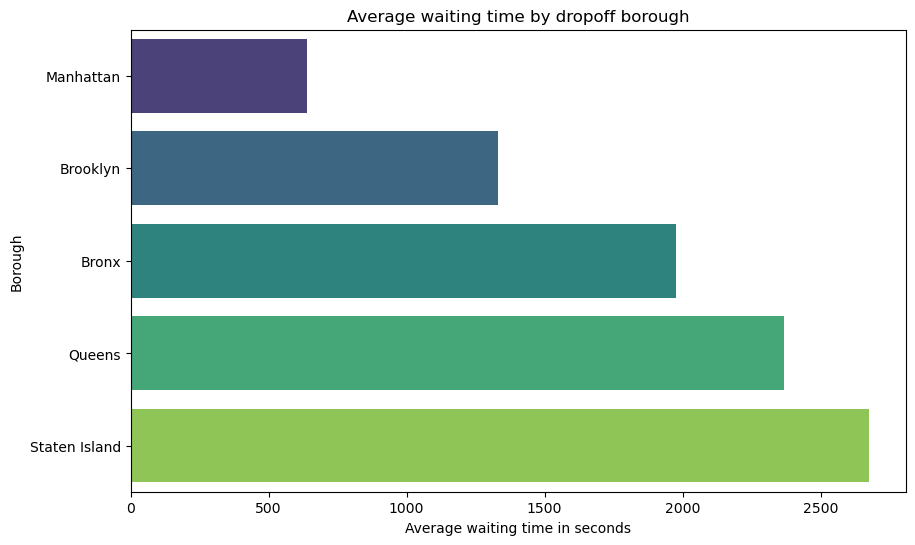

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vizualise
query2_pandas = query2_result.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=query2_pandas, x="avg_waiting_time", y="borough_name", hue="borough_name", palette="viridis", legend=False)
plt.xlabel("Average waiting time in seconds")
plt.ylabel("Borough")
plt.title("Average waiting time by dropoff borough")
plt.show()

### Query 3
The number of trips that started and ended within the same borough

In [9]:
# Filter df to only include trips that start and end in same borough, group by pickup boroughs
same_borough_trips_df = taxi_df.filter(col("pickup_borough") == col("dropoff_borough")).groupBy("pickup_borough").agg(count("*").alias("trip_count"))

# Put borough names and codes in new df to be used in next step
borough_names_df = spark.createDataFrame([(code, name) for code, name in b_names.items()],
                                        ["borough_code", "borough_name"])

# Replace borough codes w borough names
same_borough_trips_named = same_borough_trips_df.join(
    borough_names_df,
    same_borough_trips_df.pickup_borough == borough_names_df.borough_code,
    "left"
)

# Show results'
print("The number of trips that started and ended in the same borough per borough:")
same_borough_trips_named = same_borough_trips_named.select("borough_name", "trip_count")
same_borough_trips_named.show()

The number of trips that started and ended in the same borough per borough:
+-------------+----------+
| borough_name|trip_count|
+-------------+----------+
|    Manhattan|  12375437|
|     Brooklyn|    188957|
|Staten Island|       521|
|       Queens|    179061|
|        Bronx|      5761|
+-------------+----------+



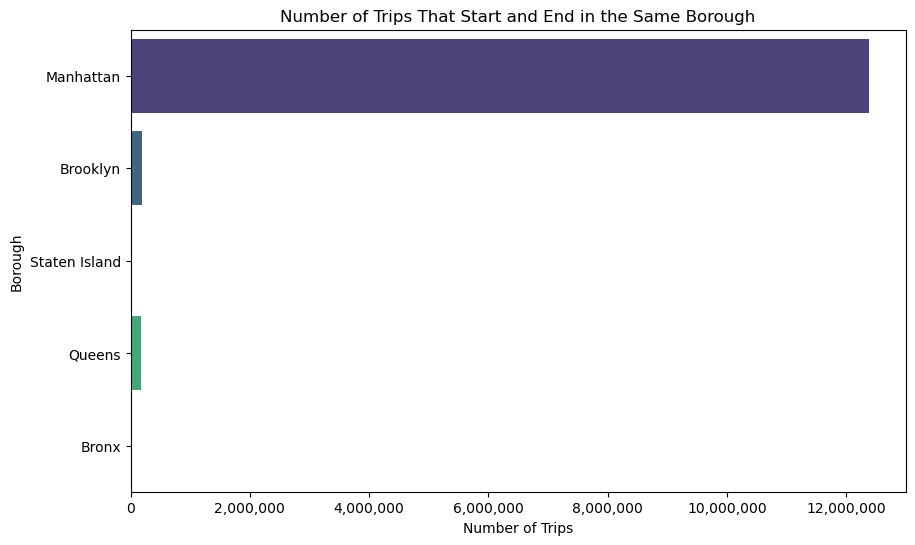

In [22]:
import matplotlib.ticker as ticker
# Vizualise
same_borough_trips_pandas = same_borough_trips_named.toPandas()
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=same_borough_trips_pandas, x="trip_count", y="borough_name", hue="borough_name", palette="viridis", legend=False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ','))) # Disable scientific numbers
plt.xlabel("Number of Trips")
plt.ylabel("Borough")
plt.title("Number of Trips That Start and End in the Same Borough")
plt.show()

### Query 4
The number of trips that started in one borough and ended in another one

In [10]:
different_borough_trips_df = (taxi_df.filter(col("pickup_borough") != col("dropoff_borough")).groupBy("pickup_borough", "dropoff_borough").agg(count("*").alias("trip_count")))

# Create a separate aliased df for pickup and dropoff borough names
borough_names_pickup = borough_names_df.alias("pickup")
borough_names_dropoff = borough_names_df.alias("dropoff")

# First join for pickup borough names
pickup_joined = different_borough_trips_df.join(
    borough_names_pickup,
    different_borough_trips_df.pickup_borough == borough_names_pickup.borough_code,
    "left"
).withColumnRenamed("borough_name", "pickup_borough_name")

# Second join for dropoff borough names
final_joined = pickup_joined.join(
    borough_names_dropoff,
    pickup_joined.dropoff_borough == borough_names_dropoff.borough_code,
    "left"
).withColumnRenamed("borough_name", "dropoff_borough_name")

# Show results
print("The number of trips that started and ended in the different boroughs per borough:")
result_q4 = final_joined.select("pickup_borough_name", "dropoff_borough_name", "trip_count")
result_q4.orderBy(col("trip_count").desc()).show()

The number of trips that started and ended in the different boroughs per borough:
+-------------------+--------------------+----------+
|pickup_borough_name|dropoff_borough_name|trip_count|
+-------------------+--------------------+----------+
|          Manhattan|              Queens|    460647|
|          Manhattan|            Brooklyn|    439578|
|             Queens|           Manhattan|    402290|
|           Brooklyn|           Manhattan|    118422|
|             Queens|            Brooklyn|     81561|
|          Manhattan|               Bronx|     50053|
|           Brooklyn|              Queens|     17328|
|             Queens|               Bronx|      9752|
|              Bronx|           Manhattan|      2890|
|          Manhattan|       Staten Island|      1924|
|             Queens|       Staten Island|       619|
|           Brooklyn|               Bronx|       498|
|              Bronx|              Queens|       271|
|           Brooklyn|       Staten Island|       128|


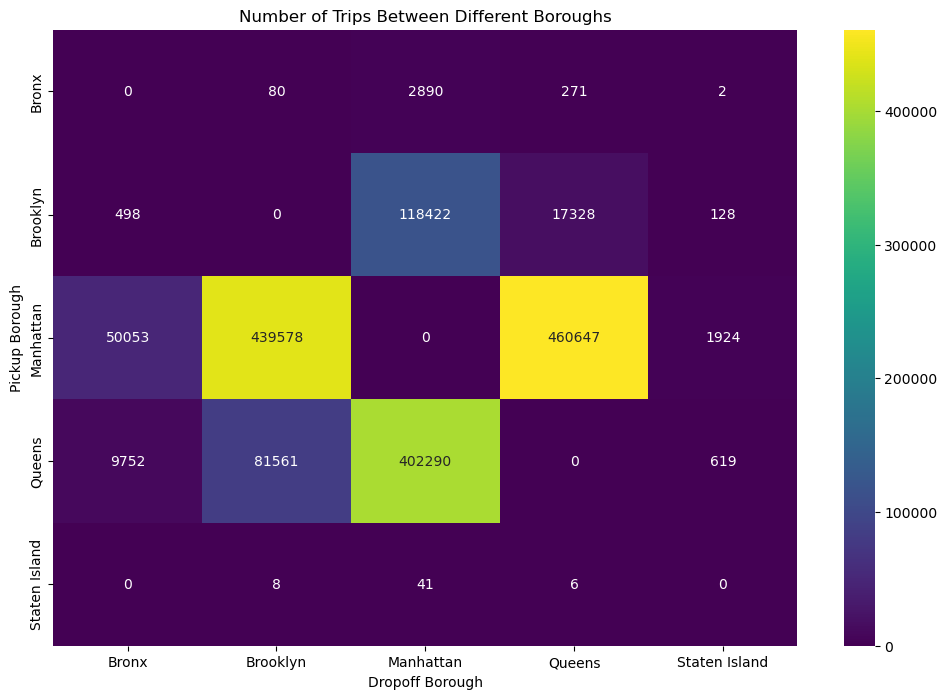

In [26]:
result_q4_pandas = result.toPandas()

# Create the bar plot
heatmap_data = result_q4_pandas.pivot_table(index="pickup_borough_name", columns="dropoff_borough_name", values="trip_count", fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="viridis")
plt.title("Number of Trips Between Different Boroughs")
plt.xlabel("Dropoff Borough")
plt.ylabel("Pickup Borough")
plt.show()